In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import ndfeature, greyscale, centralize, normalize_norm, normalize_std
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import PartsAAMBuilder, PartsAAMFitter
from alaborticcv2015.deepconvkernel.generative import GenerativeLDCN, learn_pca_filters

# PCA-Network AAMs Parameter Optimization

Load training data:

In [2]:
training_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=None):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    training_images.append(i)

- Loading 811 assets: [====================] 100%

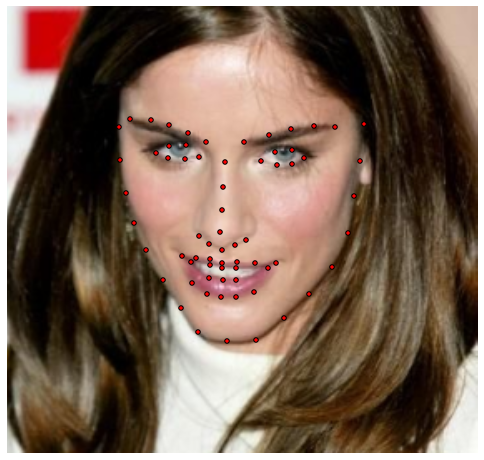

In [3]:
visualize_images(training_images)

Load test data:

In [4]:
test_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/testset/', verbose=True, 
                           max_images=None):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    test_images.append(i)

- Loading 224 assets: [====================] 100%

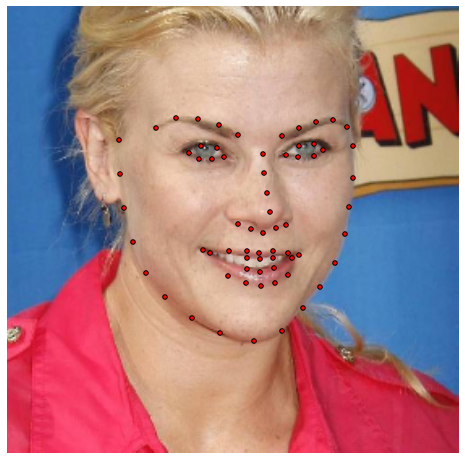

In [5]:
visualize_images(test_images)

Load pre-trained PCA LDCN:

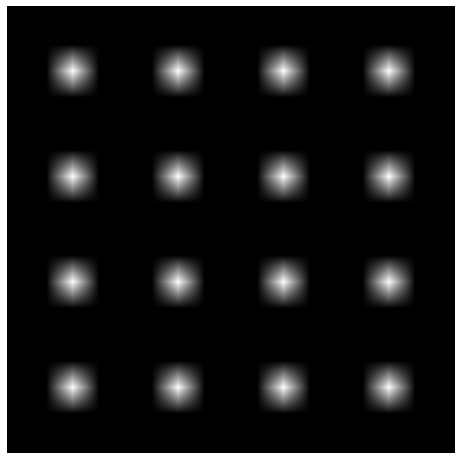

In [6]:
n_filters = range(4, 18, 2)
shapes = [s for s in range(5, 19, 2)]

sampling_mask = np.require(np.zeros((17, 17)), dtype=np.bool)
sampling_mask[2::4, 2::4] = True
Image(sampling_mask).view()

In [7]:
count = 0
results = []
for nf in n_filters:
    for s in shapes:
        
        string = '- Network {}, {}: '.format(nf, s)
        
        string2 = string + 'Building AAM '
        print_dynamic('{}{}'.format(
            string2, progress_bar_str(0, show_bar=True)))
        
        file_name = ('/data/PhD/Models/alaborticcv2015/pca_net_' 
                     + str(nf) 
                     + '_' 
                     + str(s)
                     + '.pkl.gz') 
        
        net = mio.import_pickle(file_name)
        
        def kernel_features(pixels):
            pixels = greyscale(pixels)
            pixels = net.kernel_response(pixels)
            return pixels
        
        builder = PartsAAMBuilder(features=kernel_features,
                                  diagonal=100, 
                                  norm_func=None,
                                  max_appearance_components=100)

        aam = builder.build(training_images, 
                            group='ibug_face_66')
        
        fitter = PartsAAMFitter(aam, 
                                n_shape=[3, 12], 
                                n_appearance=100, 
                                sampling_mask=sampling_mask)
        
        string2 = string + 'Building AAM '
        print_dynamic('{}{}'.format(
            string2, progress_bar_str(1, show_bar=True)))
        
        np.random.seed(seed=1)
        fitter_results = []
        for j, i in enumerate(test_images):
            string2 = string + 'Fitting images '
            print_dynamic('{}{}'.format(
                string2, progress_bar_str(j/len(test_images), show_bar=True)))
            gt_s = i.landmarks['ibug_face_66'].lms
            s = fitter.perturb_shape(gt_s, noise_std=0.05)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, map_inference=False)
            fr.downscale = 0.5
            fitter_results.append(fr)
            
        results.append(fitter_results)
        
        errors = [fr.final_error() for fr in fitter_results]
        
        mean = np.mean(errors)
        median = np.median(errors)
        std = np.std(errors)
        
        print_dynamic(string + 
                      '\tMean={0:.4f}  Median={1:.4f}  Std={2:.4f}\n'
                      .format(mean, median, std))

- Network 4, 5: 	Mean=0.0595  Median=0.0470  Std=0.0380
- Network 4, 7: 	Mean=0.0495  Median=0.0348  Std=0.0358
- Network 4, 9: 	Mean=0.0475  Median=0.0353  Std=0.0360
- Network 4, 11: 	Mean=0.0466  Median=0.0322  Std=0.0351
- Network 4, 13: 	Mean=0.0454  Median=0.0326  Std=0.0332
- Network 4, 15: 	Mean=0.0461  Median=0.0352  Std=0.0311
- Network 4, 17: 	Mean=0.0476  Median=0.0377  Std=0.0288
- Network 6, 5: 	Mean=0.0615  Median=0.0519  Std=0.0383
- Network 6, 7: 	Mean=0.0519  Median=0.0356  Std=0.0383
- Network 6, 9: 	Mean=0.0491  Median=0.0361  Std=0.0355
- Network 6, 11: 	Mean=0.0468  Median=0.0331  Std=0.0341
- Network 6, 13: 	Mean=0.0459  Median=0.0327  Std=0.0337
- Network 6, 15: 	Mean=0.0464  Median=0.0340  Std=0.0322
- Network 6, 17: 	Mean=0.0473  Median=0.0373  Std=0.0305
- Network 8, 5: 	Mean=0.0621  Median=0.0527  Std=0.0384
- Network 8, 7: 	Mean=0.0530  Median=0.0359  Std=0.0387
- Network 8, 9: 	Mean=0.0490  Median=0.0357  Std=0.0354
- Network 8, 11: 	Mean=0.0464  Median=0.

/data/pythondev/src/menpo/menpo/image/base.py:130: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '
